In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [5]:
# Load the datasets
train_data_path = r"Credit Card Fraud Detection dataset\fraudTrain.csv"
test_data_path = r"Credit Card Fraud Detection dataset\fraudTest.csv"


train_data = pd.read_csv(train_data_path)
test_data = pd.read_csv(test_data_path)

# Combine the train and test data
full_data = pd.concat([train_data, test_data])

# Basic data inspection
print(full_data.head())
print(full_data.info())


   Unnamed: 0 trans_date_trans_time            cc_num  \
0           0   2019-01-01 00:00:18  2703186189652095   
1           1   2019-01-01 00:00:44      630423337322   
2           2   2019-01-01 00:00:51    38859492057661   
3           3   2019-01-01 00:01:16  3534093764340240   
4           4   2019-01-01 00:03:06   375534208663984   

                             merchant       category     amt      first  \
0          fraud_Rippin, Kub and Mann       misc_net    4.97   Jennifer   
1     fraud_Heller, Gutmann and Zieme    grocery_pos  107.23  Stephanie   
2                fraud_Lind-Buckridge  entertainment  220.11     Edward   
3  fraud_Kutch, Hermiston and Farrell  gas_transport   45.00     Jeremy   
4                 fraud_Keeling-Crist       misc_pos   41.96      Tyler   

      last gender                        street  ...      lat      long  \
0    Banks      F                561 Perry Cove  ...  36.0788  -81.1781   
1     Gill      F  43039 Riley Greens Suite 393  ...  48

Unnamed: 0               0
trans_date_trans_time    0
cc_num                   0
merchant                 0
category                 0
amt                      0
first                    0
last                     0
gender                   0
street                   0
city                     0
state                    0
zip                      0
lat                      0
long                     0
city_pop                 0
job                      0
dob                      0
trans_num                0
unix_time                0
merch_lat                0
merch_long               0
is_fraud                 0
dtype: int64


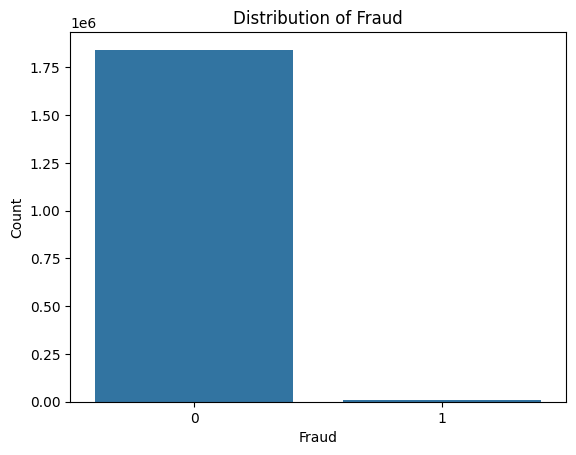

Number of duplicate records:  0


In [24]:
# Drop missing values
full_data = full_data.dropna()

# Check for null values after dropping
print(full_data.isnull().sum())

# Plot the distribution of fraud
fraud_counts = full_data['is_fraud'].value_counts()
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title('Distribution of Fraud')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.show()

# Check for duplicated records
print("Number of duplicate records: ", full_data.duplicated().sum())


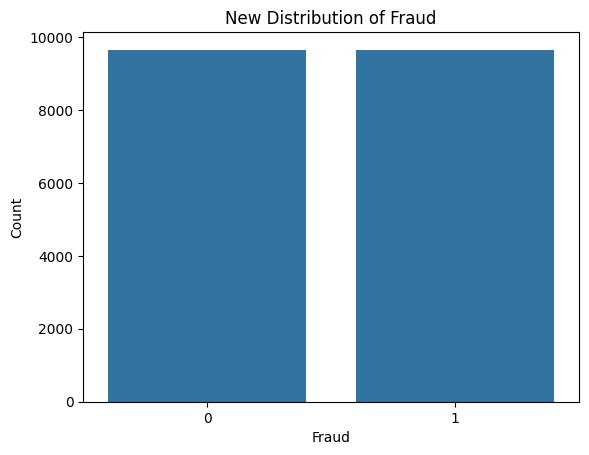

In [7]:
# Make data balanced by sampling
fraud = full_data[full_data['is_fraud'] == 1]
not_fraud = full_data[full_data['is_fraud'] == 0]
not_fraud = not_fraud.sample(fraud.shape[0])

# Combine the balanced dataset
data = pd.concat([fraud, not_fraud])

# Plot the new distribution of fraud
fraud_counts = data['is_fraud'].value_counts()
sns.barplot(x=fraud_counts.index, y=fraud_counts.values)
plt.title('New Distribution of Fraud')
plt.xlabel('Fraud')
plt.ylabel('Count')
plt.show()


In [8]:
# Feature Engineering
# Drop unnecessary columns
unused_cols = ['Unnamed: 0', 'first', 'last', 'unix_time', 'street', 'gender', 'job', 'dob', 'city', 'state', 'trans_num', 'merchant']
data.drop(columns=unused_cols, inplace=True)

# Convert date column to datetime and extract relevant features
data['trans_date_trans_time'] = pd.to_datetime(data['trans_date_trans_time'])
data['trans_day'] = data['trans_date_trans_time'].dt.day
data['trans_month'] = data['trans_date_trans_time'].dt.month
data['trans_year'] = data['trans_date_trans_time'].dt.year
data['trans_hour'] = data['trans_date_trans_time'].dt.hour
data['trans_minute'] = data['trans_date_trans_time'].dt.minute

# Drop the original datetime column
data.drop(columns=['trans_date_trans_time'], inplace=True)

# Check the modified DataFrame structure
data.info()


<class 'pandas.core.frame.DataFrame'>
Index: 19302 entries, 2449 to 1276226
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   cc_num        19302 non-null  int64  
 1   category      19302 non-null  object 
 2   amt           19302 non-null  float64
 3   zip           19302 non-null  int64  
 4   lat           19302 non-null  float64
 5   long          19302 non-null  float64
 6   city_pop      19302 non-null  int64  
 7   merch_lat     19302 non-null  float64
 8   merch_long    19302 non-null  float64
 9   is_fraud      19302 non-null  int64  
 10  trans_day     19302 non-null  int32  
 11  trans_month   19302 non-null  int32  
 12  trans_year    19302 non-null  int32  
 13  trans_hour    19302 non-null  int32  
 14  trans_minute  19302 non-null  int32  
dtypes: float64(5), int32(5), int64(4), object(1)
memory usage: 2.0+ MB


In [9]:
# Encoding categorical variables
encoder = LabelEncoder()
data['category'] = encoder.fit_transform(data['category'])
data['cc_num'] = encoder.fit_transform(data['cc_num'])

# Check the head of the modified data
data.head()


,cc_num,category,amt,zip,lat,long,city_pop,merch_lat,merch_long,is_fraud,trans_day,trans_month,trans_year,trans_hour,trans_minute
2449,126,4,281.06,28611,35.9946,-81.7266,885,36.430124,-81.179483,1,2,1,2019,1,6
2472,314,2,11.52,78208,29.4400,-98.4590,1595797,29.819364,-99.142791,1,2,1,2019,1,47
2523,314,4,276.31,78208,29.4400,-98.4590,1595797,29.273085,-98.836360,1,2,1,2019,3,5
2546,126,2,7.03,28611,35.9946,-81.7266,885,35.909292,-82.091010,1,2,1,2019,3,38
2553,314,4,275.73,78208,29.4400,-98.4590,1595797,29.786426,-98.683410,1,2,1,2019,3,55


In [11]:
# Extract features (X) and target variable (y)
X = data.drop('is_fraud', axis=1)
y = data['is_fraud']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# Check the shapes of the split data
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)


(15441, 14) (3861, 14) (15441,) (3861,)


In [12]:
# Model Building and Training

# Bagging: Random Forest
bagging_model = RandomForestClassifier(n_estimators=100, random_state=0)

# Boosting: Gradient Boost
boosting_model = GradientBoostingClassifier(n_estimators=100, random_state=0)

# Stacking: A combination of Random Forest, Decision Tree, and SVM with Logistic Regression as the final estimator
base_learners = [
    ('rf', RandomForestClassifier(n_estimators=50, random_state=0)),
    ('dt', DecisionTreeClassifier(random_state=0)),
    ('svm', SVC(probability=True, random_state=0))
]

stacking_model = StackingClassifier(estimators=base_learners, final_estimator=LogisticRegression())

# Train the models
bagging_model.fit(X_train, y_train)
boosting_model.fit(X_train, y_train)
stacking_model.fit(X_train, y_train)


StackingClassifier(estimators=[('rf',
                                RandomForestClassifier(n_estimators=50,
                                                       random_state=0)),
                               ('dt', DecisionTreeClassifier(random_state=0)),
                               ('svm', SVC(probability=True, random_state=0))],
                   final_estimator=LogisticRegression())

In [13]:
# Make predictions with each model
bagging_pred = bagging_model.predict(X_test)
boosting_pred = boosting_model.predict(X_test)
stacking_pred = stacking_model.predict(X_test)

# Evaluate each model
def evaluate_model(y_true, y_pred, model_name):
    print(f"\n{model_name} Model Evaluation:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred)}")
    print(f"Precision: {precision_score(y_true, y_pred)}")
    print(f"Recall: {recall_score(y_true, y_pred)}")
    print(f"F1 Score: {f1_score(y_true, y_pred)}")
    print(f"Confusion Matrix:\n{confusion_matrix(y_true, y_pred)}")

# Evaluate Bagging
evaluate_model(y_test, bagging_pred, 'Bagging')

# Evaluate Boosting
evaluate_model(y_test, boosting_pred, 'Boosting')

# Evaluate Stacking
evaluate_model(y_test, stacking_pred, 'Stacking')



Bagging Model Evaluation:
Accuracy: 0.9663299663299664
Precision: 0.9669291338582677
Recall: 0.964903090623363
F1 Score: 0.9659150498164657
Confusion Matrix:
[[1889   63]
 [  67 1842]]

Boosting Model Evaluation:
Accuracy: 0.9621859621859622
Precision: 0.9607945635128071
Recall: 0.962807752750131
F1 Score: 0.9618001046572475
Confusion Matrix:
[[1877   75]
 [  71 1838]]

Stacking Model Evaluation:
Accuracy: 0.9712509712509713
Precision: 0.9687174139728885
Recall: 0.9732844421162913
F1 Score: 0.9709955578782336
Confusion Matrix:
[[1892   60]
 [  51 1858]]


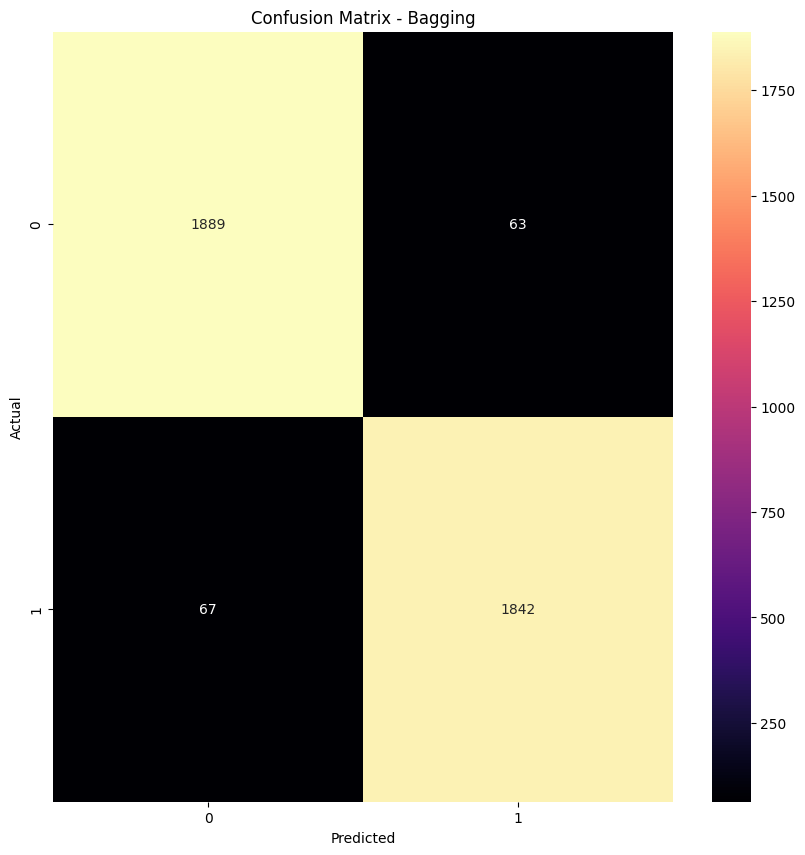

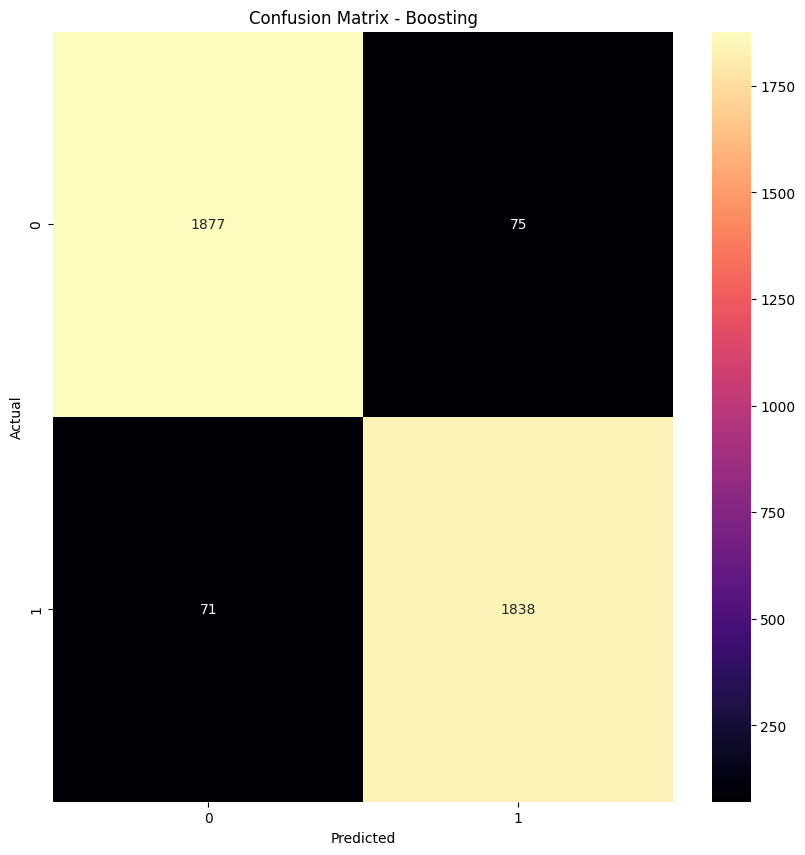

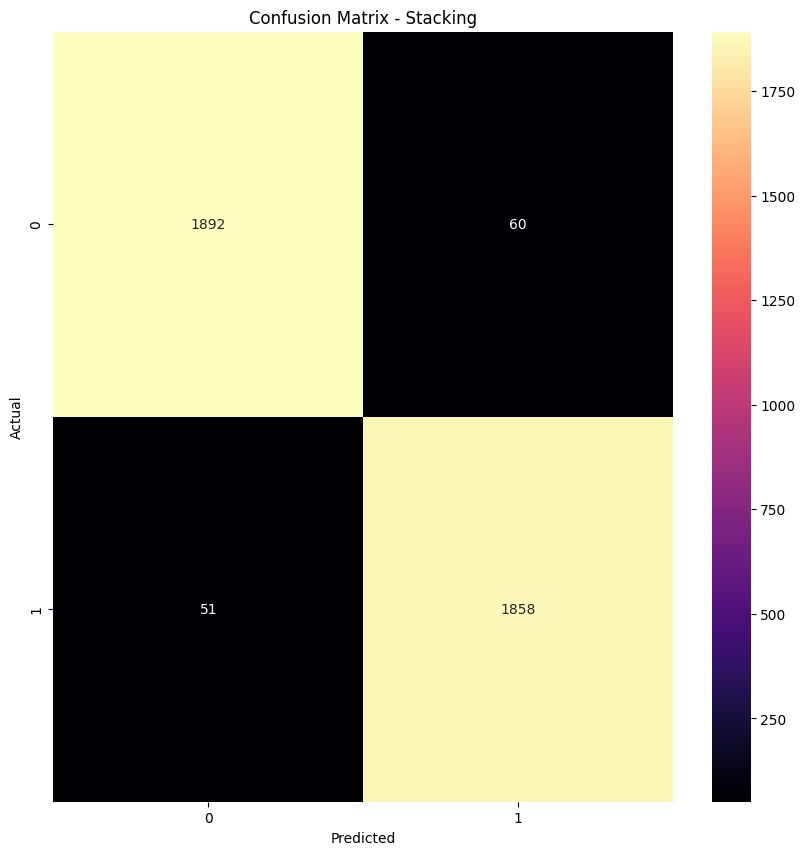

In [20]:
# Plot confusion matrix function
def plot_confusion_matrix(y_true, y_pred, model_name):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='magma')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

# Bagging Confusion Matrix
plot_confusion_matrix(y_test, bagging_pred, 'Bagging')

# Boosting Confusion Matrix
plot_confusion_matrix(y_test, boosting_pred, 'Boosting')

# Stacking Confusion Matrix
plot_confusion_matrix(y_test, stacking_pred, 'Stacking')

